# Tentando digitalizar documentos a partir de fotos do mesmo

Para isso, está sendo usado como base [esse tutorial](https://www.makeuseof.com/python-create-document-scanner/)

## Instalando bibliotecas necessárias

In [1]:
%pip install OpenCV-Python imutils scikit-image NumPy

Note: you may need to restart the kernel to use updated packages.


## Importando bibliotecas necessárias

In [2]:
import cv2
import imutils
from skimage.filters import threshold_local
from matplotlib import pyplot as plt
import ipywidgets as widgets
from time import sleep

import numpy as np
# from transform import perspective_transform

## Lendo imagem

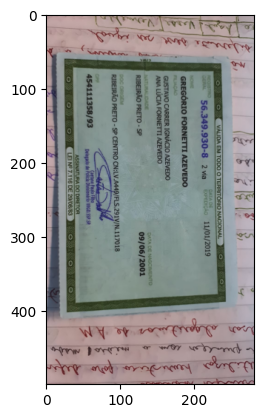

In [3]:

original_img = cv2.imread('../../imgs_teste/4.jpeg')
copy = original_img.copy()


ratio = original_img.shape[0] / 500.0
img_resize = imutils.resize(original_img, height=500)
plt.imshow(img_resize)

plt.show()


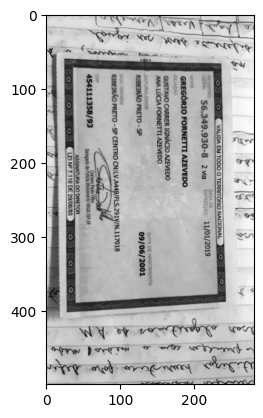

In [4]:

gray_image = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

## Aplicando o detector de cantos

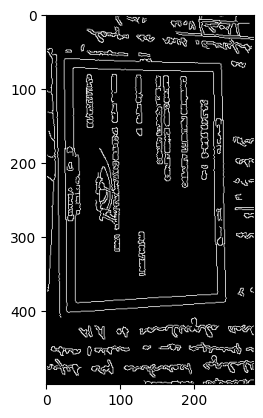

In [5]:
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

edged_img = cv2.Canny(blurred_image, 75, 200)

plt.imshow(edged_img, cmap='gray')
plt.show()

In [6]:
cnts, _ = cv2.findContours(edged_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(approx) == 4:
        doc = approx
        break

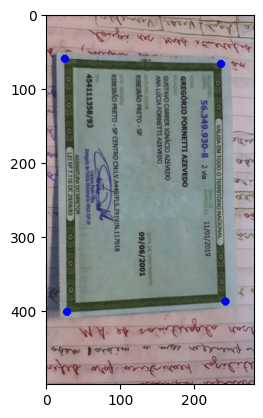

In [7]:
p = []

for d in doc:
    tuple_point = tuple(d[0])
    cv2.circle(img_resize, tuple_point, 3, (0, 0, 255), 4)
    p.append(tuple_point)

plt.imshow(img_resize)
plt.show()

## Transformando a imagem (digitalização)

In [8]:
def order_points(pts):
   # initializing the list of coordinates to be ordered
   rect = np.zeros((4, 2), dtype = "float32")

   s = pts.sum(axis = 1)

   # top-left point will have the smallest sum
   rect[0] = pts[np.argmin(s)]

   # bottom-right point will have the largest sum
   rect[2] = pts[np.argmax(s)]

   '''computing the difference between the points, the
   top-right point will have the smallest difference,
   whereas the bottom-left will have the largest difference'''
   diff = np.diff(pts, axis = 1)
   rect[1] = pts[np.argmin(diff)]
   rect[3] = pts[np.argmax(diff)]

   # returns ordered coordinates
   return rect

In [9]:
def perspective_transform(image, pts):
   # unpack the ordered coordinates individually
   rect = order_points(pts)
   (tl, tr, br, bl) = rect

   '''compute the width of the new image, which will be the
   maximum distance between bottom-right and bottom-left
   x-coordinates or the top-right and top-left x-coordinates'''
   widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
   widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
   maxWidth = max(int(widthA), int(widthB))

   '''compute the height of the new image, which will be the
   maximum distance between the top-left and bottom-left y-coordinates'''
   heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
   heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
   maxHeight = max(int(heightA), int(heightB))

   '''construct the set of destination points to obtain an overhead shot'''
   dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")

   # compute the perspective transform matrix
   transform_matrix = cv2.getPerspectiveTransform(rect, dst)

   # Apply the transform matrix
   warped = cv2.warpPerspective(image, transform_matrix, (maxWidth, maxHeight))

   # return the warped image
   return warped

## Aplicando a digitalização

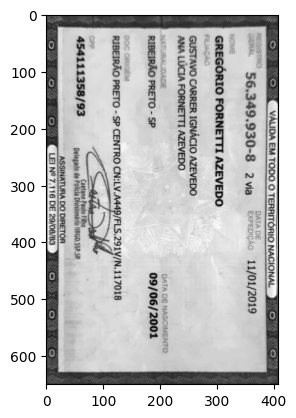

In [10]:
warped_image = perspective_transform(copy, doc.reshape(4, 2) * ratio)
warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)

plt.imshow(imutils.resize(warped_image, height=650), cmap='gray')
plt.show()

## Aplicando digitalização em tempo real

### Transformando em funções

In [11]:
def find_points(img):
    doc = None
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    edged_img = cv2.Canny(blurred_image, 75, 200)

    cnts, _ = cv2.findContours(edged_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    print(len(cnts))
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            doc = approx
            break
    
    if doc is not None:
        p = []

        for d in doc:
            tuple_point = tuple(d[0])
            cv2.circle(img, tuple_point, 3, (0, 0, 255), 4)
            p.append(tuple_point)

        return p
    else:
        return False

### Criando interface para digitalização em tempo real

In [12]:
raw_img_widget = widgets.Image(
    format='jpg',
    width=600,
    height=400
)

digitalizar_btn = widgets.Button(
    description='Digitalizar',
    button_style='success',
    icon='check'
)

digitalized_img_widget = widgets.Image(
    format='jpg',
    width=600,
    height=400
)

In [13]:

display(raw_img_widget)
display(digitalizar_btn)
display(digitalized_img_widget)
delay_in_seconds = 0.1

camera = cv2.VideoCapture(0)
while True:
    ret, frame = camera.read()
    points = find_points(frame)
    raw_img_widget.value = cv2.imencode('.jpg', frame)[1].tobytes()
    sleep(delay_in_seconds)
    pass
camera.release()

Image(value=b'', format='jpg', height='400', width='600')

Button(button_style='success', description='Digitalizar', icon='check', style=ButtonStyle())

Image(value=b'', format='jpg', height='400', width='600')

0
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


KeyboardInterrupt: 